In [1]:
import numpy as np
import matplotlib.pyplot as plt
with open("piste.pgm", 'rb') as pgmf:
    img = plt.imread(pgmf)
    
img_t = np.transpose(img)
img_t = np.flip(img_t, 1)

In [2]:
import cmath
def cart2polC(xyz):
    x, y, z = xyz
    return(cmath.polar(complex(x, y))) # rho, phi
def convert_array(arr):
    theta = []
    r = []
    for x in arr:
        rho, phi = cart2polC(x)
        theta.append(phi)
        r.append(rho)
    return theta, r    

In [3]:
min_range = 2.0
max_range = 12000.0
resolution = 1 # in degrees
def lidar_filer(raw_scann):
    scann = []
    samples = np.arange(-np.pi, np.pi, np.radians(resolution))
    for sample in samples:
        mask = (raw_scann[:,0] > sample - np.radians(resolution) / 2) & (raw_scann[:,0] < sample + np.radians(resolution) / 2)
        if sum(mask) == 0:
            dist = 0
        else:
            dist = raw_scann[mask][:, 1].min()
        scann.append(dist)
        if dist > max_range:
            scann[-1] = None
        if dist < min_range:
            scann[-1] = None
    return np.roll(np.array(scann), int(np.pi / np.radians(resolution)))       

In [4]:
def get_point_cloud(pose, img_t):
    threshold = 250
    width = img_t.shape[0]
    height = img_t.shape[1]
    t = np.mgrid[:width, :height]
    t = np.stack((t[0], t[1]), axis=2)
    points = t[img_t < threshold]
    theta = -pose[2]
    rot_matrix = np.array([[np.cos(theta), -np.sin(theta),0],
                           [np.sin(theta), np.cos(theta), 0],
                           [0, 0, 1]])

    trans_matrix = np.array([[1, 0, -pose[0]],
                            [0, 1, -pose[1]],
                            [0, 0, 1]])

    points_pose = np.transpose(trans_matrix @ np.vstack([np.transpose(points), np.ones(points.shape[0])]))
    points_pose = np.transpose(rot_matrix @ np.transpose(points_pose))
    return points_pose

In [5]:
def get_lidar_scann(pose, img_t):
    points_pose = get_point_cloud(pose, img_t)
    theta, r = convert_array(points_pose)
    return lidar_filer(np.stack((theta, r), axis=1))

In [6]:
def get_longest_distance(scann):
    view_angle = 180  # degrees
    sample_each_side = int(len(scann) / 360 * view_angle / 2)
    max_distance = 0
    max_index = 0
    for i in range(sample_each_side):
        if scann[i] is None:
            continue
        if scann[i] > max_distance:
            max_distance = scann[i]
            max_index = i
        if scann[-i] is None:
            continue
        if scann[-i] > max_distance:
            max_distance = scann[-i]
            max_index = -i

    return max_index

In [7]:
pose = [900, 50, np.pi]
pose = [850, 52, 3.0892327760299634]
pose = [800, 60, 2.9845130209103035]
pose = [753, 77, 2.792526803190927]
#pose = [715, 110, 2.426007660272118]
pose = [500, 50, np.pi + np.radians(-3)]
pose = [ 166.648113,  213.283612,  0.20943951]
pose = [ 215.555493,  223.679196,  0.20943951]
pose = [260.735529, 234.518542, 0.2268928 ]
pose = [107.199835, 189.184783, 1.30899694]
pose = [100, 189.184783, 1.30899694]

In [8]:
lidar_scann = get_lidar_scann(pose, img_t)
points_pose = get_point_cloud(pose, img_t)
theta, r = convert_array(points_pose)

In [9]:
plot_scann = np.stack((np.arange(0, 2 * np.pi, np.radians(resolution)), lidar_scann), axis=1)
plot_scann = plot_scann[plot_scann[:, 1] != np.array(None)]

In [10]:
target_index = get_longest_distance(lidar_scann)
target_point = [np.radians(resolution) * target_index, lidar_scann[target_index]]

In [11]:
target_angle = np.radians(resolution) * target_index
print(np.degrees(target_angle))

-89.0


In [12]:
target_line = np.stack(([0., 0.], target_point))

Text(0.5, 1.0, 'Lidar Scann')

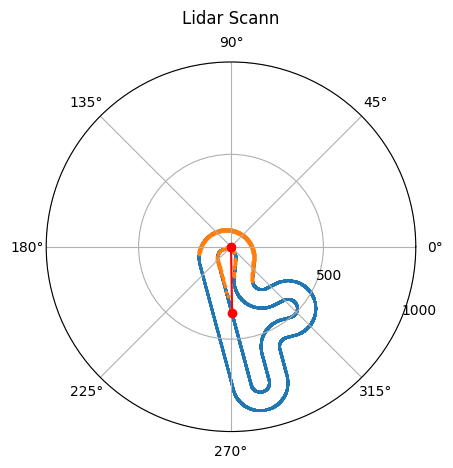

In [13]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(target_line[:, 0], target_line[:, 1], 'ro-')
ax.scatter(theta, r, s=1.0)
ax.scatter(plot_scann[:, 0], plot_scann[:, 1], s=3.0)
ax.set_rmax(1000)
ax.set_rticks([500, 1000])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Lidar Scann", va='bottom')

In [14]:
def calc_cmd_vel(pose, img_t):
    vel_max = 1.0 # m/sec
    lidar_scann = get_lidar_scann([pose[0] * 100, pose[1] * 100, pose[2]], img_t)
    target_index = get_longest_distance(lidar_scann)
    # angel in map coordinate system
    angular_z = pose[2] + np.radians(resolution) * target_index
    linear_x = vel_max
    return {"linear_x": linear_x, "angular_z": angular_z}

In [15]:
def get_odom(cmd_vel, pose, dt):
    x = pose[0] + cmd_vel["linear_x"] * np.cos(cmd_vel["angular_z"]) * dt
    y = pose[1] + cmd_vel["linear_x"] * np.sin(cmd_vel["angular_z"]) * dt
    return [x, y, cmd_vel["angular_z"]]

In [16]:
way_points = []
dt = 0.4
pose = [9, 0.5, np.pi]
way_points.append(pose)
for i in range(22):
    pose = get_odom(calc_cmd_vel(pose, img_t), pose, dt)
    way_points.append(pose)

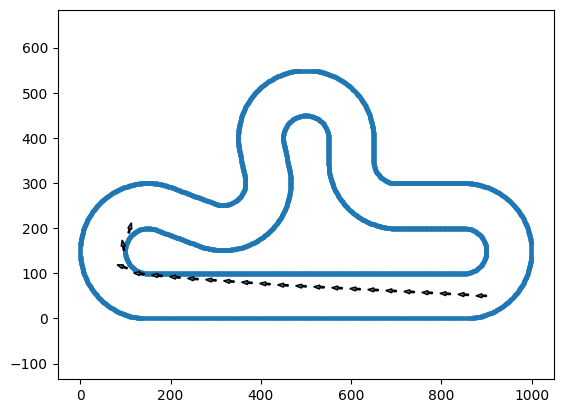

In [17]:
threshold = 250
width = img_t.shape[0]
height = img_t.shape[1]
t = np.mgrid[:width, :height]
t = np.stack((t[0], t[1]), axis=2)
points = t[img_t < threshold]
path = np.array(way_points)

fig, ax = plt.subplots(1, 1)
ax.axis('equal')
ax.scatter(points[:, 0], points[:, 1], s=3.0)
for i in range(path.shape[0]):
    ax.arrow(path[i, 0] * 100, path[i, 1] * 100, 10 * np.cos(path[i, 2]), 10 * np.sin(path[i, 2]), width=3.0)

In [18]:
path

array([[9.        , 0.5       , 3.14159265],
       [8.60054819, 0.52093438, 3.08923278],
       [8.20109637, 0.54186876, 3.08923278],
       [7.80164456, 0.56280315, 3.08923278],
       [7.40219274, 0.58373753, 3.08923278],
       [7.00274093, 0.60467191, 3.08923278],
       [6.60328912, 0.62560629, 3.08923278],
       [6.2038373 , 0.64654068, 3.08923278],
       [5.80438549, 0.66747506, 3.08923278],
       [5.40493367, 0.68840944, 3.08923278],
       [5.00548186, 0.70934382, 3.08923278],
       [4.60603005, 0.73027821, 3.08923278],
       [4.20700443, 0.7581808 , 3.07177948],
       [3.80797881, 0.78608339, 3.07177948],
       [3.40895319, 0.81398598, 3.07177948],
       [3.00992757, 0.84188857, 3.07177948],
       [2.61090195, 0.86979115, 3.07177948],
       [2.21242407, 0.90465345, 3.05432619],
       [1.81394619, 0.93951575, 3.05432619],
       [1.41613743, 0.98132713, 3.0368729 ],
       [1.03793   , 1.1115544 , 2.8099801 ],
       [0.96847073, 1.5054775 , 1.74532925],
       [1.

In [19]:
np.degrees(2.7925268)

159.99999981717335